# Detect claims to fact check in political debates

In this project you will implement various classifiers using both neural and feature based technqiues to detect which sentences in political debates should be fact checked.
Dataset from ClaimBuster: https://zenodo.org/record/3609356 
Evaluate your classifiers using the same metrics as http://ranger.uta.edu/~cli/pubs/2017/claimbuster-kdd17-hassan.pdf (Table 2)

Classification report from sklearn provides everything

In [2]:
# TODO:  Create advanced model(s) (suggestions are given below)
#           -- Generate more features that a model can use. For example the context around the sentence, sentiment, named entities etc.
#           -- Rule based classifier. For example, if sentence contains certain words, tags, statistics etc.
#           -- Deep learning (word embeddings, transformer models etc.)
#           -- Sub-sentence classifier. Long sentences may include several claims, so the goal is to mark the span of claim(s) within a sentence

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import collections
import string

from sklearn.cluster import KMeans
from sklearn.metrics import *
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier

import json
import glob
import re
import time 

# Loading and merging the data

In [4]:
file1 = pd.read_csv("data/crowdsourced.csv", encoding='utf-8')
file2 = pd.read_csv("data/groundtruth.csv", encoding='utf-8')
df = pd.concat([file1, file2])


df["date"] = df["File_id"].str.strip(to_strip=".txt")

df["date"] = pd.to_datetime(df["date"])
df.sort_values("date", inplace= True)
df["mos_before_election"] = 11 - df["date"].dt.month

df['index'] = pd.RangeIndex(len(df))
df.set_index('index', inplace=True)
df


,Sentence_id,Text,Speaker,Speaker_title,Speaker_party,File_id,Length,Line_number,Sentiment,Verdict,date,mos_before_election
index,,,,,,,,,,,,
0,8211,"Now, this is not standing still.",Richard M. Nixon,Vice President,REPUBLICAN,1960-09-26.txt,6,114,-0.417840,-1,1960-09-26,2
1,8515,So these are three programs which are quite mo...,John F. Kennedy,Senator,DEMOCRAT,1960-09-26.txt,9,418,0.249581,-1,1960-09-26,2
2,8514,The proposal advanced by you and by Mr. Javits...,John F. Kennedy,Senator,DEMOCRAT,1960-09-26.txt,42,417,-0.626563,1,1960-09-26,2
3,8513,It does not put a deficit on the Treasury.,John F. Kennedy,Senator,DEMOCRAT,1960-09-26.txt,9,416,-0.629486,1,1960-09-26,2
4,8512,The third is medical care for the aged which i...,John F. Kennedy,Senator,DEMOCRAT,1960-09-26.txt,22,415,0.000000,-1,1960-09-26,2
...,...,...,...,...,...,...,...,...,...,...,...,...
23528,34028,"First of all, the media is so dishonest and so...",Donald Trump,Businessman,REPUBLICAN,2016-10-19.txt,17,907,0.032300,-1,2016-10-19,1
23529,34027,What I've seen -- what I've seen is so bad.,Donald Trump,Businessman,REPUBLICAN,2016-10-19.txt,9,906,-0.669600,-1,2016-10-19,1
23530,34026,I'll look at it at the time.,Donald Trump,Businessman,REPUBLICAN,2016-10-19.txt,7,905,0.000000,-1,2016-10-19,1


# Data preprocessing

In [5]:
def remove_punctuation(text):
    tokens = re.sub('[^a-zA-Z]', ' ', text).lower()
    return tokens

In [6]:
def remove_stop_words(text):
    stop_words = stopwords.words('english')
    word_list = [word for word in text.split() if word not in stop_words]
    return word_list

In [7]:
def get_word_stemm(word_list):
    """Stemmers remove morphological affixes from words, leaving only the word stem."""
    stemmer = SnowballStemmer('english')
    singles = [stemmer.stem(word) for word in word_list] 
    return singles

In [8]:
def preprocess_data(docs):

    text_list = [] 
    for doc in docs:  
        # 1. Remove punctuation and set as lower case
        text = remove_punctuation(doc)

        # 2. Remove stop words and extra spaces
        word_list = remove_stop_words(text)
        joined_text = " ".join(word_list)
        text_list.append(joined_text)
        
        # 3. Stemming
        # word_stem = get_word_stemm(word_list)
        # joined_text = " ".join(word_stem)
        # text_list.append(joined_text)


    return text_list



In [9]:
data = preprocess_data(df.Text.values)

In [10]:
# add clean text to dataframe
df["Clean_text"] = pd.Series(data)

In [11]:
df.head()

,Sentence_id,Text,Speaker,Speaker_title,Speaker_party,File_id,Length,Line_number,Sentiment,Verdict,date,mos_before_election,Clean_text
index,,,,,,,,,,,,,
0,8211,"Now, this is not standing still.",Richard M. Nixon,Vice President,REPUBLICAN,1960-09-26.txt,6,114,-0.417840,-1,1960-09-26,2,standing still
1,8515,So these are three programs which are quite mo...,John F. Kennedy,Senator,DEMOCRAT,1960-09-26.txt,9,418,0.249581,-1,1960-09-26,2,three programs quite moderate
2,8514,The proposal advanced by you and by Mr. Javits...,John F. Kennedy,Senator,DEMOCRAT,1960-09-26.txt,42,417,-0.626563,1,1960-09-26,2,proposal advanced mr javits would cost six hun...
3,8513,It does not put a deficit on the Treasury.,John F. Kennedy,Senator,DEMOCRAT,1960-09-26.txt,9,416,-0.629486,1,1960-09-26,2,put deficit treasury
4,8512,The third is medical care for the aged which i...,John F. Kennedy,Senator,DEMOCRAT,1960-09-26.txt,22,415,0.000000,-1,1960-09-26,2,third medical care aged tied social security f...


# Train-test split


In [12]:
mask = df["date"].dt.year < 2012

X_train = df.loc[mask, "Clean_text"].values
y_train = df.loc[mask, "Verdict"].values

X_test = df.loc[~mask, "Clean_text"].values
y_test = df.loc[~mask, "Verdict"].values

# TF-idf

In [15]:
vectorizer = TfidfVectorizer(max_df=0.6, stop_words='english')
X_train = vectorizer.fit_transform(X_train)
print("n_samples: %d, n_features: %d" % X_train.shape)
X_test = vectorizer.transform(X_test)
print("n_samples: %d, n_features: %d" % X_test.shape)

feature_names = vectorizer.get_feature_names_out()



n_samples: 18170, n_features: 10022
n_samples: 5363, n_features: 10022


# Base line model

1. SVM
2. KNN
3. Perceptron
4. Naive Bayes
5. Decision Tree 
5. Random Forest

In [13]:
import time 

def baseline(clf):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time.time()
    pred = clf.predict(X_test)
    test_time = time.time() - t0
    print("test time:  %0.3fs" % test_time)

    score = accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    print()
    print("                       Classification report")
    report = classification_report(y_test, pred, target_names= ["NFS", "UFS", "CFS"])
    print(report)

    return {
            "score": score,
            "report": report, 
            "train_time": train_time, 
            "test_time": test_time, 
            }


In [14]:
results = {}

clfs = [
        ("SVM", svm.SVC(kernel='linear')), 
        ("KNN", KNeighborsClassifier(n_neighbors=20)), 
        ("Perceptron", Perceptron(max_iter=100)),
        ("NB", ComplementNB()),
        ("DT", DecisionTreeClassifier()),
        ("RF", RandomForestClassifier(min_samples_split=5))
        ]   

for classifier in clfs:
    result = baseline(classifier[1])  
    results.setdefault(classifier[0], result)


________________________________________________________________________________
Training: 
SVC(kernel='linear')
train time: 12.338s
test time:  2.117s
accuracy:   0.707

                       Classification report
              precision    recall  f1-score   support

         NFS       0.72      0.93      0.81      3314
         UFS       0.52      0.15      0.23       623
         CFS       0.67      0.43      0.52      1426

    accuracy                           0.71      5363
   macro avg       0.64      0.50      0.52      5363
weighted avg       0.69      0.71      0.67      5363

________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=20)
train time: 0.002s
test time:  3.058s
accuracy:   0.621

                       Classification report
              precision    recall  f1-score   support

         NFS       0.62      1.00      0.77      3314
         UFS       0.58      0.01      0.02       623
         

In [15]:
results.keys()

dict_keys(['SVM', 'KNN', 'Perceptron', 'NB', 'DT', 'RF'])

In [13]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.binary):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

accuracy:   0.707
Confusion matrix, without normalization


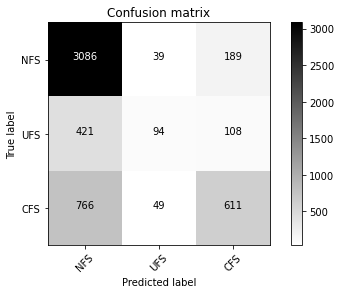

In [16]:
clf = svm.SVC(kernel='linear')

clf.fit(X_train, y_train)
pred = clf.predict(X_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=["NFS", "UFS", "CFS"])